In [1]:
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import osmnx as ox
import planarity
import warnings
from shapely.geometry import Point, Polygon

from planar_analysis import *

ox.config(use_cache=True, log_console=True)
%matplotlib inline

In [2]:
# config
query = 'Oakland, California, USA'
n = 200
distance = 805
network_type = 'drive'
np.random.seed(1)

In [3]:
def save_spatial_data(city, network_type, bbox, G, planar_intersections, nonplanar_intersections, cleaned_intersections):
    ox.save_graph_shapefile(G, filename='graph_city/{}-{}'.format(city, network_type), folder='data')
    planar_intersections.to_file('data/graph_city/{}-{}/planar'.format(city, network_type))
    nonplanar_intersections.to_file('data/graph_city/{}-{}/nonplanar'.format(city, network_type))
    cleaned_intersections.to_file('data/graph_city/{}-{}/cleaned'.format(city, network_type))
    north, south, east, west = bbox
    polygon = Polygon([(west, north), (west, south), (east, south), (east, north)])
    gpd.GeoSeries([polygon]).to_file('data/graph_city/{}-{}/bbox'.format(city, network_type))

## Random points across a single city

In [4]:
def random_points_within(poly, n):
    
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    
    while len(points) < n:
        rand_x = np.random.uniform(min_x, max_x)
        rand_y = np.random.uniform(min_y, max_y)
        rand_pt = Point((rand_x, rand_y))
        if (rand_pt.within(poly)):
            points.append((rand_x, rand_y))

    return points

In [5]:
gdf = ox.gdf_from_place(query)
poly = gdf.loc[0, 'geometry']
points = np.array(random_points_within(poly, n=n))

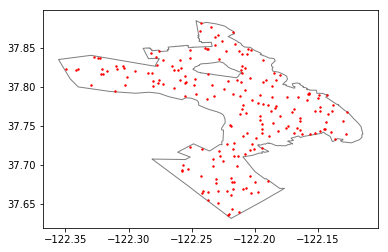

In [6]:
x = points[:,0]
y = points[:,1]
fig, ax = plt.subplots()
gdf.plot(ax=ax, facecolor='w', edgecolor='gray')
ax.scatter(x=x, y=y, s=2, c='r')
plt.show()

In [7]:
places = {}
for i, point in enumerate(points):
    name = '{:002d}_{}'.format(i, query)
    latlng = (point[1], point[0])
    places[name] = latlng

In [8]:
results = []
for name, coords in places.items():

    try:

        ox.log('working on {} - {}.'.format(name, distance))
        start_time = time.time()
        G_ = get_graph(coords, distance, network_type)
        G_proj = ox.project_graph(G_)

        # get a special buffered graph for planar analysis
        buffer = 500
        G_buff_ = get_graph(coords, distance + buffer, network_type)
        G_buff_proj = ox.project_graph(G_buff_)

        # get a bounding box to trim things square
        north, south, east, west = ox.bbox_from_point(coords, distance, project_utm=True)
        bbox = Polygon([(west, north), (west, south), (east, south), (east, north)])

        # how many planar line intersections are there?
        planar_intersections = calculate_planar_intersections(G_buff_proj, bbox)
        count_planar_intersections = len(planar_intersections)

        # how many nonplanar graph edge intersections are there?
        nonplanar_intersections = calculate_nonplanar_intersections(G_buff_proj, bbox)
        count_nonplanar_intersections = len(nonplanar_intersections)

        # how many cleaned, clustered intersections are there?
        cleaned_intersections = calculate_cleaned_intersections(nonplanar_intersections)
        count_cleaned_intersections = len(cleaned_intersections)

        # how does planarity affect average edge length?
        mean_edge_length, mean_planar_segment_length, edge_length_ratio = calculate_edge_length_ratios(G_proj, planar_intersections)
        
        # is it a formally planar graph (ignoring spatial embedding)?
        warnings.filterwarnings('ignore')
        is_planar = planarity.is_planar(G_proj)
        warnings.resetwarnings()
                
        if count_nonplanar_intersections > 0:
            # planar line intersections overcounts nonplanar graph edge intersections by xx%
            # ie, planar graph shows xx% more intersections than nonplanar graph with bridges/tunnels
            planar_nonplanar_overcount = count_planar_intersections / count_nonplanar_intersections
            phi = 1 / planar_nonplanar_overcount
        else:
            planar_nonplanar_overcount = None #avoid divide by zero errors
            phi = None

        if count_cleaned_intersections > 0:
            # edge intersections overcounts street intersections by xx%
            nonplanar_cleaned_overcount = count_nonplanar_intersections / count_cleaned_intersections

            # line intersections overcounts street intersections by xx%
            planar_cleaned_overcount = count_planar_intersections / count_cleaned_intersections
        else:
            planar_cleaned_overcount = None #avoid divide by zero errors
            nonplanar_cleaned_overcount = None
        
        # save shapefiles to disk for visual inspection
        bbox = ox.bbox_from_point(coords, distance)
        save_spatial_data(name, network_type, bbox, G_proj, planar_intersections, nonplanar_intersections, cleaned_intersections)
        
        # assemble the results
        result = {'name' : name,
                  'coords' : coords,
                  'distance' : distance,
                  'network_type' : network_type,
                  'nodes' : len(G_proj.nodes()),
                  'count_planar_intersections' : count_planar_intersections,
                  'count_nonplanar_intersections' : count_nonplanar_intersections,
                  'count_cleaned_intersections' : count_cleaned_intersections,
                  'overcount_planar_nonplanar' : planar_nonplanar_overcount,
                  'overcount_nonplanar_cleaned' : nonplanar_cleaned_overcount,
                  'overcount_planar_cleaned' : planar_cleaned_overcount,
                  'mean_edge_length' : mean_edge_length,
                  'mean_planar_segment_length' : mean_planar_segment_length,
                  'edge_length_ratio' : edge_length_ratio,
                  'phi' : phi,
                  'is_planar' : is_planar,
                  'runtime' : time.time() - start_time}
        results.append(result)

    except Exception as e:
        print(name, coords, e)

03_Oakland, California, USA (37.66936916490881, -122.21739866649688) There are no data elements in the response JSON objects
07_Oakland, California, USA (37.836610645606505, -122.32228629155598) 'Polygon' object is not iterable
10_Oakland, California, USA (37.69222748383268, -122.25743472994276) There are no data elements in the response JSON objects
12_Oakland, California, USA (37.823465428061894, -122.33996116433788) 'osmid'
15_Oakland, California, USA (37.63694641212645, -122.22055546184355) There are no data elements in the response JSON objects
16_Oakland, California, USA (37.6667685487342, -122.2217108493994) There are no data elements in the response JSON objects
18_Oakland, California, USA (37.63540444592944, -122.2208722264757) There are no data elements in the response JSON objects
19_Oakland, California, USA (37.683688056008556, -122.21885005568075) There are no data elements in the response JSON objects
24_Oakland, California, USA (37.68542986921786, -122.20398746984884) 'o

In [9]:
df = pd.DataFrame(results)
df.to_csv('data/city_samples.csv')

## Get the whole city

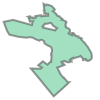

In [10]:
gdf = ox.gdf_from_place(query)
poly = gdf.loc[0, 'geometry']
poly_proj, crs_proj = ox.project_geometry(poly)
poly

In [11]:
start_time = time.time()
G_ = ox.graph_from_place(query, network_type=network_type,
                         simplify=True, truncate_by_edge=True, retain_all=True)
G_proj = ox.project_graph(G_)

# get a special buffered graph for planar line analysis
buffer = 500
G_buff_ = ox.graph_from_place(query, network_type=network_type, buffer_dist=buffer,
                              simplify=True, truncate_by_edge=True, retain_all=True)
G_buff_proj = ox.project_graph(G_buff_)

# how many planar line intersections are there?
planar_intersections = calculate_planar_intersections(G_buff_proj, bbox=poly_proj)
count_planar_intersections = len(planar_intersections)

# how many nonplanar graph edge intersections are there?
nonplanar_intersections = calculate_nonplanar_intersections(G_proj, bbox=poly_proj)
count_nonplanar_intersections = len(nonplanar_intersections)

# how many cleaned, clustered intersections are there?
cleaned_intersections = calculate_cleaned_intersections(nonplanar_intersections)
count_cleaned_intersections = len(cleaned_intersections)

# how does planarity affect average edge length?
mean_edge_length, mean_planar_segment_length, edge_length_ratio = calculate_edge_length_ratios(G_proj, planar_intersections)

if count_nonplanar_intersections > 0:
    # planar line intersections overcounts nonplanar graph edge intersections by xx%
    # ie, planar graph shows xx% more intersections than nonplanar graph with bridges/tunnels
    planar_nonplanar_overcount = count_planar_intersections / count_nonplanar_intersections
    phi = 1 / planar_nonplanar_overcount
else:
    planar_nonplanar_overcount = None #avoid divide by zero errors
    phi = None

if count_cleaned_intersections > 0:
    # edge intersections overcounts street intersections by xx%
    nonplanar_cleaned_overcount = count_nonplanar_intersections / count_cleaned_intersections

    # line intersections overcounts street intersections by xx%
    planar_cleaned_overcount = count_planar_intersections / count_cleaned_intersections
else:
    planar_cleaned_overcount = None #avoid divide by zero errors
    nonplanar_cleaned_overcount = None

# assemble the results
result = {'name' : query,
          'network_type' : network_type,
          'nodes' : len(G_proj.nodes()),
          'count_planar_intersections' : count_planar_intersections,
          'count_nonplanar_intersections' : count_nonplanar_intersections,
          'count_cleaned_intersections' : count_cleaned_intersections,
          'overcount_planar_nonplanar' : planar_nonplanar_overcount,
          'overcount_nonplanar_cleaned' : nonplanar_cleaned_overcount,
          'overcount_planar_cleaned' : planar_cleaned_overcount,
          'mean_edge_length' : mean_edge_length,
          'mean_planar_segment_length' : mean_planar_segment_length,
          'edge_length_ratio' : edge_length_ratio,
          'phi' : phi,
          'runtime' : time.time() - start_time}

In [12]:
# is it a formally planar graph (ignoring spatial embedding)?
warnings.filterwarnings('ignore')
is_planar = planarity.is_planar(G_proj)
warnings.resetwarnings()
is_planar

False

In [13]:
# results for the entire city
pd.Series(result)

count_cleaned_intersections                          6471
count_nonplanar_intersections                        7397
count_planar_intersections                           8074
edge_length_ratio                                0.929354
mean_edge_length                                  132.827
mean_planar_segment_length                        123.443
name                             Oakland, California, USA
network_type                                        drive
nodes                                                8427
overcount_nonplanar_cleaned                        1.1431
overcount_planar_cleaned                          1.24772
overcount_planar_nonplanar                        1.09152
phi                                              0.916151
runtime                                           7815.42
dtype: object